In [18]:
import numpy as np
import scipy
import scipy.linalg
import fbpca 
import random
import time

def prep_data():
    x = np.loadtxt("simulated_genos", delimiter=" ", dtype="float32")
    y = np.array([[1] * 10000 + [0] * 10000], dtype="float32")
    y_c = y - 0.5
    return x, y_c

x, y_c = prep_data()
print (x.shape)


(20000, 50)


# Singular Value Decomposition (SVD)
Computing the Singular Value Decomposition (SVD) is a fundamental linear algebra primitive, ubiquitous in machine learning, statistics, signal processing, and other fields. Formally, the SVD of a real m × n matrix A is a factorization of the form A = U Σ Vᵀ, where U is an m × m orthogonal matrix of left singular vectors, Σ is an m × n diagonal matrix of singular values, and Vᵀ is an n × n orthogonal matrix of right singular vectors.

The SVD provides a roadmap to computing a low-rank approximation for A– that is, finding a matrix Aᵣ with rank r < m, n such that ||Aᵣ – A|| is minimized. Given A = U Σ Vᵀ, we can approximate A by the following procedure:

Sort the nonzero elements of Σ in decreasing order;
Take the first r elements of Σ (say Σᵣ, an r × r diagonal matrix), the corresponding columns of U (Uᵣ, an m × r orthogonal matrix) and the corresponding columns of V (Vᵣ, an n × r orthogonal matrix);
Take Aᵣ = Uᵣ Σᵣ Vᵣᵀ.

# Randomized Matrix Approximation

here, we’ll focus on some modern randomized matrix approximation techniques, developed in (amongst others) in Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions, a 2009 paper by Nathan Halko, Per-Gunnar Martinsson and Joel A. Tropp. 
https://arxiv.org/abs/0909.4061

## 1. FBPCA package for randomized SVD
This package is developed by facebook research.
Relavant links:
http://fbpca.readthedocs.io/en/latest/



In [6]:
# fbpca
import fbpca 
%time sig_rsvd_fbpca = fbpca.pca(x,50,True)[1]
eig_rsvd_fbpca = sig_rsvd_fbpca ** 2
print (eig_rsvd_fbpca)


CPU times: user 62.1 ms, sys: 17.2 ms, total: 79.3 ms
Wall time: 102 ms
[ 40.00001144  38.08315277  37.10234833  37.06640244  37.00000763
  33.04753876  31.16459846  29.1289978   29.07105446  29.03992844
  28.99998474  28.00000381  27.65703964  26.03939819  25.52819252
  25.03122902  25.00000572  24.00005341  23.99998283  22.00000954
  21.93363762  21.00001335  20.68578529  20.00000572  20.00000572
  19.80418396  17.82784653  16.94734573  16.          15.99999428
  14.92892456  13.00000191  11.99999332  11.95249748  11.00000381
  10.99999619  10.00000668  10.00000286  10.           9.00000286
   7.99999857   7.00000095   7.00000095   6.99999952   6.00000286   5.           4.
   4.           3.96006298   1.        ]


Here is our own implementation of randomized SVD. After reduce the dimention, we use np.linalg.svd (the svd function in numpy) to conduct svd on a smaller scale matrix

In [7]:
#randomized SVD
def randomized_svd(M, k=10):
    m, n = M.shape
    transpose = False
    if m < n:
        transpose = True
        M = M.T
        
    rand_matrix = np.random.normal(size=(M.shape[1], k))  # short side by k
    Q, _ = np.linalg.qr(M @ rand_matrix, mode='reduced')  # long side by k
    smaller_matrix = Q.T @ M                              # k by short side
    U_hat, s, V = np.linalg.svd(smaller_matrix, full_matrices=False)
    U = Q @ U_hat
    
    if transpose:
        return V.T, s.T, U.T
    else:
        return U, s, V
    
%time sig_rsvd = randomized_svd(x,50)[1]
eig_rsvd = sig_rsvd_fbpca ** 2
print (eig_rsvd)

CPU times: user 111 ms, sys: 32.6 ms, total: 144 ms
Wall time: 98.6 ms
[ 40.00001144  38.08315277  37.10234833  37.06640244  37.00000763
  33.04753876  31.16459846  29.1289978   29.07105446  29.03992844
  28.99998474  28.00000381  27.65703964  26.03939819  25.52819252
  25.03122902  25.00000572  24.00005341  23.99998283  22.00000954
  21.93363762  21.00001335  20.68578529  20.00000572  20.00000572
  19.80418396  17.82784653  16.94734573  16.          15.99999428
  14.92892456  13.00000191  11.99999332  11.95249748  11.00000381
  10.99999619  10.00000668  10.00000286  10.           9.00000286
   7.99999857   7.00000095   7.00000095   6.99999952   6.00000286   5.           4.
   4.           3.96006298   1.        ]


Also, we have scipy's function for computing eigen values for sparse matrix

In [8]:

#exact:
from scipy import sparse
import scipy.sparse.linalg as lg
X_sparse = sparse.csr_matrix(x)
X_T_sparse = sparse.csr_matrix.transpose(X_sparse)
XX = X_sparse@X_T_sparse
%time eig_exact = lg.eigsh(XX,k=50)
eig_exact = eig_exact[0]
eig_exact_sorted = sorted(eig_exact,reverse = True)
print (eig_exact_sorted)


CPU times: user 153 ms, sys: 6.51 ms, total: 160 ms
Wall time: 89.3 ms
[40.000004, 38.083111, 37.102303, 37.066376, 37.0, 33.047508, 31.164608, 29.128977, 29.071066, 29.039927, 28.999994, 27.999996, 27.657045, 26.039396, 25.5282, 25.031216, 24.999994, 24.000002, 23.999996, 21.999994, 21.933632, 21.000002, 20.685768, 20.0, 19.99999, 19.804171, 17.827816, 16.947344, 15.999999, 15.999992, 14.928935, 13.000005, 12.0, 11.952488, 11.000002, 10.999996, 10.000003, 10.000001, 9.999999, 9.0000029, 8.0000019, 7.0000081, 7.000001, 6.9999986, 6.0000091, 5.0000143, 4.0000048, 3.9999919, 3.9600658, 0.99999535]


# Comparsion of different methods
Here, we compare the randomized SVD methods (approximate methods) to the exact methods (scipy's), in terms of computing time and accuracy.

#### compare approximate methods to exact method's eigenvalue

In [9]:
# compare approximate methods to exact method's eigen
eig_rsvd = list(eig_rsvd)

total_error = 0
for i in range(len(eig_rsvd)):
    error = abs(eig_rsvd[i]-eig_exact_sorted[i])
    total_error += error
mean_error = total_error/len(eig_rsvd)
print ("total error: ")
print (total_error)
print ("average error:")
print (mean_error)

total error: 
0.000535845756531
average error:
1.07169151306e-05


#### compute P-value, by Monte Carlo simulation, the distribution of Q

0.7828660000000001


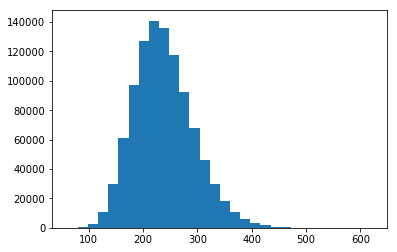

In [12]:
# Monte Carlo, simulate the distribution of Q
import matplotlib.pyplot as plt
%matplotlib inline


N = 1000000

Q_distribution = []
for i in range(N):
    #generate 50 chi-square r.v
    sample = np.random.chisquare(1, size=50)
    Q_stat = np.sum(eig_exact * sample)/4
    Q_distribution.append(Q_stat)
    

#print (Q_distribution)
plt.hist(Q_distribution, bins = 30)
q = 223.25
def inverse_percentile(arr, num):
    arr = sorted(arr)
    i_arr = [i for i, x in enumerate(arr) if x > num]

    return i_arr[0] / len(arr) if len(i_arr) > 0 else 1
abs_Q_distribution = abs(Q_distribution - np.average(Q_distribution))
q_abs = abs(q-np.average(Q_distribution))
p = 1- inverse_percentile(abs_Q_distribution, q_abs)
print (p)



### benchmark, comparsion of computing time
Here are our steps to compute the computing time, with different size of K*K matrix:
1. generate 50 random eigen value according to N(real eigen value,0.1), accordingly.
2. generate a random K*50, orthogonal matrix X, K >50, using the scipy function, scipy.linalg.orth
3. compute $X \Lambda  X^{T}$ , where $ \Lambda  $ is the 50*50 diagonal matrix with 50 eigenvalues, accordingly.
4. using  eigen methods on $X \Lambda  X^{T}$, and the computing time, with average of 1000 times of computing for each K

In [27]:

#generate 50 random eigen value according to N(real eigen value,0.1)

print (eig_exact)
random_eigen = [0]*50
for i in range(50):
    random_eigen[i]= float(np.random.normal(eig_exact[i], 0.1, 1))
print (random_eigen)

#generate K*50, orthogonal matrix, K >50
import scipy
K = 100
a = np.random.random(size=(K, 50))
q = scipy.linalg.orth(a)
print (q)
I = np.identity(50)
E = I*random_eigen
M = q @ E @ q.T
print (M)
import time

X_sparse = sparse.csr_matrix(q)
X_T_sparse = sparse.csr_matrix.transpose(X_sparse)
XX = X_sparse@E@X_T_sparse
start_time = time.clock()
eig_2 = lg.eigsh(XX,k=50)
end_time = time.clock()
eig_2 = eig_2[0]
print (eig_2)
print (end_time - start_time)

[[-0.0973257   0.11556493  0.08731847 ...,  0.02507832  0.06528766
   0.01759556]
 [-0.11334519  0.14854615 -0.1579003  ...,  0.0657426   0.04356572
  -0.09522703]
 [-0.11026109  0.00578262  0.01771882 ...,  0.18526249  0.14341826
  -0.16599502]
 ..., 
 [-0.10235634  0.04291876  0.05122064 ..., -0.043659   -0.1681546
   0.1182403 ]
 [-0.09778275 -0.08527034 -0.21115958 ..., -0.04515087 -0.05654244
   0.13090622]
 [-0.09178478 -0.22044286  0.02379291 ..., -0.06872249 -0.19076769
   0.10581162]]
(100, 100)


Here are the functions to test average running time for computing eigenvalues for different methods

(0.00524902299999917, array([  1.07042263,   3.88847997,   3.91954555,   4.02155654,
         5.12766639,   5.89313308,   6.9530751 ,   7.0012983 ,
         7.19444368,   8.10682994,   9.04966198,   9.80336425,
         9.83089019,  10.07918536,  10.96196389,  11.06235327,
        11.89035624,  12.11788171,  13.07394175,  14.76239531,
        15.90512725,  16.01414024,  17.00351365,  17.87744637,
        19.78752863,  20.0031318 ,  20.0464879 ,  20.8550785 ,
        20.93276191,  21.79857358,  21.96992874,  23.86702913,
        24.02494727,  24.96627638,  25.14302706,  25.5509677 ,
        26.01233751,  27.71491217,  28.08811381,  29.00288825,
        29.07165083,  29.16051431,  29.20807506,  31.10977925,
        32.80298801,  36.99257841,  37.05965941,  37.13969989,
        37.94605951,  39.97900011]))
[0.00031658900000024914, 0.0003871160000001055, 0.00043879900000047203, 0.0004686599999995451, 0.0005894370000021354, 0.0005498940000002221, 0.000747791999999663, 0.0007716670000020258,

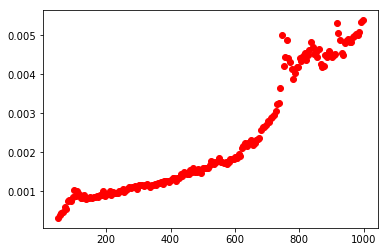

In [46]:
# function to test average running time for computing eigen
#function 1, testing the computing time of scipy function
def test_eigen_1(K):
    random_eigen = [0]*50
    for i in range(50):
        random_eigen[i]= float(np.random.normal(eig_exact[i], 0.1, 1))
    a = np.random.random(size=(K, 50))
    q = scipy.linalg.orth(a)
    I = np.identity(50)
    E = I*random_eigen
    M = q @ E @ q.T
    X_sparse = sparse.csr_matrix(q)
    X_T_sparse = sparse.csr_matrix.transpose(X_sparse)
    XX = X_sparse@E@X_T_sparse
    time_list = []
    for j in range(100):
        start_time = time.clock()
        eig_2 = lg.eigsh(XX,k=50)
        end_time = time.clock()
        time_list.append(end_time-start_time)
    average_time = sum(time_list)/1000
    eig_2 = eig_2[0]
    return (average_time, eig_2)
    

    


In [ ]:
#function 2, testing the computing time of randomized SVD function
def test_rsvd_1(K):
    random_eigen = [0]*50
    for i in range(50):
        random_eigen[i]= float(np.random.normal(eig_exact[i], 0.1, 1))
    a = np.random.random(size=(K, 50))
    q = scipy.linalg.orth(a)
    I = np.identity(50)
    E = I*np.sqrt(random_eigen)
    X_sparse = sparse.csr_matrix(q)   
    XX = X_sparse@E
    time_list = []
    for j in range(100):
        start_time = time.clock()
        eig_2 = randomized_svd(XX,50)
        end_time = time.clock()
        time_list.append(end_time-start_time)
    average_time = sum(time_list)/1000
    eig_2 = eig_2[0]
    return (average_time, eig_2)


#print (test_eigen_1(1000))
#compute list of runing time vs. K
k_list = range(100,1000,5)
time_list = [test_rsvd_1(k)[0] for k in k_list]
#print (time_list)
import matplotlib.pyplot as plt
plt.plot(k_list, time_list, 'ro')
plt.show()

In [ ]:
# Appendix

#### Process behind Randomized SVD

Here is a process to calculate a truncated SVD, described in [Finding Structure with Randomness: Probabilistic Algorithms for Constructing Approximate Matrix Decompositions](https://arxiv.org/pdf/0909.4061.pdf) and [summarized in this blog post](https://research.fb.com/fast-randomized-svd/):

1\. Compute an approximation to the range of $A$. That is, we want $Q$ with $r$ orthonormal columns such that $$A \approx QQ^TA$$


2\. Construct $B = Q^T A$, which is small ($r\times n$)


3\. Compute the SVD of $B$ by standard methods (fast since $B$ is smaller than $A$), $B = S\,\Sigma V^T$

4\. Since $$ A \approx Q Q^T A = Q (S\,\Sigma V^T)$$ if we set $U = QS$, then we have a low rank approximation $A \approx U \Sigma V^T$.

#### So how do we find $Q$ (in step 1)?

To estimate the range of $A$, we can just take a bunch of random vectors $w_i$, evaluate the subspace formed by $Aw_i$.  We can form a matrix $W$ with the $w_i$ as it's columns.  Now, we take the QR decomposition of $AW = QR$, then the columns of $Q$ form an orthonormal basis for $AW$, which is the range of $A$.

Since the matrix $AW$ of the product has far more rows than columns and therefore, approximately, orthonormal columns. This is simple probability - with lots of rows, and few columns, it's unlikely that the columns are linearly dependent.

#### Why M ~ Q Q.T M

We are trying to find a matrix Q such that $M \approx Q Q^T M$.  We are interested in the range of $M$, let's call this $MX$.  $Q$ has orthonormal columns so $Q^TQ = I$ (but $QQ^T$ isn't $I$, since $Q$ is rectangular)

$$ QR = MX $$
$$ QQ^TQR = QQ^TMX $$
$$ QR = QQ^TMX $$
so...
$$ MX = QQ^TMX $$

If $X$ is the identity, we'd be done (but then $X$ would be too big, and we wouldn't get the speed up we're looking for).  In our problem, $X$ is just a small random matrix.  The Johnson-Lindenstrauss Lemma provides some justification of why this works.

#### The QR Decomposition

We will be learning about the QR decomposition **in depth** later on.  For now, you just need to know that $A = QR$, where $Q$ consists of orthonormal columns, and $R$ is upper triangular.  Trefethen says that the QR decomposition is the most important idea in numerical linear algebra!  We will definitely be returning to it.

#### How should we choose $r$?

Suppose our matrix has 100 columns, and we want 5 columns in U and V. To be safe, we should project our matrix onto an orthogonal basis with a few more rows and columns than 5 (let's use 15).  At the end, we will just grab the first 5 columns of U and V

So even although our projection was only approximate, by making it a bit bigger than we need, we can make up for the loss of accuracy (since we're only taking a subset later). 

# Reference
[Finding Structure with Randomness: Probabilistic Algorithms for Constructing Approximate Matrix Decompositions](https://arxiv.org/pdf/0909.4061.pdf)

[Facebook's research blog about randomized SVD](https://research.fb.com/fast-randomized-svd/)